In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

# 데이터 전처리 

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/image/for transfer learning'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                             shuffle=True, num_workers=4)
                                             shuffle=True, num_workers=0)               
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)
print(class_names)

{'train': 380, 'val': 310}
['no', 'yes']


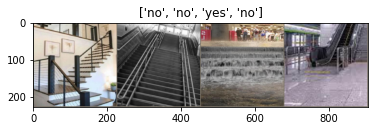

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 모델 훈련 함수 & 시각화 함수 

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                print(class_names[labels[j]])
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# 첫번째 resnet18 모델 가져오기/훈련/저장/시각화

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001,momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5880 Acc: 0.6974
val Loss: 0.2562 Acc: 0.8935

Epoch 1/24
----------
train Loss: 0.5820 Acc: 0.7711
val Loss: 0.2130 Acc: 0.9194

Epoch 2/24
----------
train Loss: 0.3967 Acc: 0.8500
val Loss: 0.3398 Acc: 0.8806

Epoch 3/24
----------
train Loss: 0.4988 Acc: 0.7895
val Loss: 0.2671 Acc: 0.8968

Epoch 4/24
----------
train Loss: 0.3902 Acc: 0.8447
val Loss: 0.3258 Acc: 0.8871

Epoch 5/24
----------
train Loss: 0.4185 Acc: 0.8579
val Loss: 0.3176 Acc: 0.8935

Epoch 6/24
----------
train Loss: 0.3009 Acc: 0.8632
val Loss: 0.3034 Acc: 0.8774

Epoch 7/24
----------
train Loss: 0.3711 Acc: 0.8211
val Loss: 0.2629 Acc: 0.8935

Epoch 8/24
----------
train Loss: 0.3441 Acc: 0.8632
val Loss: 0.2456 Acc: 0.8742

Epoch 9/24
----------
train Loss: 0.3330 Acc: 0.8474
val Loss: 0.3359 Acc: 0.8839

Epoch 10/24
----------
train Loss: 0.2911 Acc: 0.8737
val Loss: 0.2108 Acc: 0.9032

Epoch 11/24
----------
train Loss: 0.2583 Acc: 0.9079
val Loss: 0.2162 Acc: 0.8871

Ep

In [ ]:
torch.save(model_ft, "/content/drive/MyDrive/Colab Notebooks/소융대 학술제/model_ft.pth")

yes


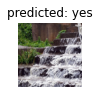

no


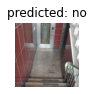

yes


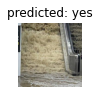

yes


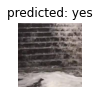

no


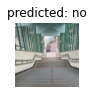

yes


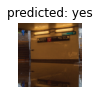

In [ ]:
visualize_model(model_ft)

# 두번째 resnet18 모델 가져오기/훈련/저장/시각화

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6135 Acc: 0.7026
val Loss: 0.3632 Acc: 0.8258

Epoch 1/24
----------
train Loss: 0.5360 Acc: 0.7447
val Loss: 0.3612 Acc: 0.8452

Epoch 2/24
----------
train Loss: 0.4400 Acc: 0.7974
val Loss: 0.3386 Acc: 0.8645

Epoch 3/24
----------
train Loss: 0.5434 Acc: 0.7763
val Loss: 0.3274 Acc: 0.8774

Epoch 4/24
----------
train Loss: 0.5635 Acc: 0.7579
val Loss: 0.4094 Acc: 0.8516

Epoch 5/24
----------
train Loss: 0.6308 Acc: 0.7711
val Loss: 0.2965 Acc: 0.9097

Epoch 6/24
----------
train Loss: 0.5456 Acc: 0.7816
val Loss: 0.3689 Acc: 0.8839

Epoch 7/24
----------
train Loss: 0.4300 Acc: 0.8079
val Loss: 0.2858 Acc: 0.8903

Epoch 8/24
----------
train Loss: 0.4491 Acc: 0.8053
val Loss: 0.3720 Acc: 0.8710

Epoch 9/24
----------
train Loss: 0.4228 Acc: 0.8132
val Loss: 0.3966 Acc: 0.8742

Epoch 10/24
----------
train Loss: 0.3878 Acc: 0.8263
val Loss: 0.3065 Acc: 0.8871

Epoch 11/24
----------
train Loss: 0.3229 Acc: 0.8605
val Loss: 0.3369 Acc: 0.8774

Ep

In [ ]:
torch.save(model_conv, "/content/drive/MyDrive/Colab Notebooks/소융대 학술제/model_conv.pth")

no


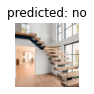

yes


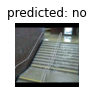

yes


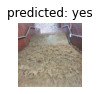

yes


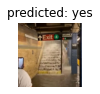

no


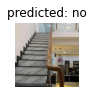

yes


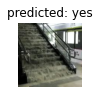

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()